# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import utils

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Create blank canvas to quilt on
    out_img = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    
    for i in range(int(out_size / patch_size)):
        for j in range(int(out_size / patch_size)):
            
            # Randomly generate coordinates from which to extract square patch
            sample_height, sample_width, _ = sample.shape
            y_rand = np.random.randint(low=0, high=(sample_height - patch_size - 1)) # Out-of-bounds protection
            x_rand = np.random.randint(low=0, high=(sample_width - patch_size - 1))
            
            for patch_i in range(patch_size):
                for patch_j in range(patch_size):
                    # Copy patch from sample to canvas
                    out_img[i * patch_size + patch_i][j * patch_size + patch_j] \
                    = sample[y_rand + patch_i][x_rand + patch_j]

    return out_img

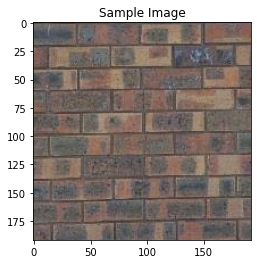

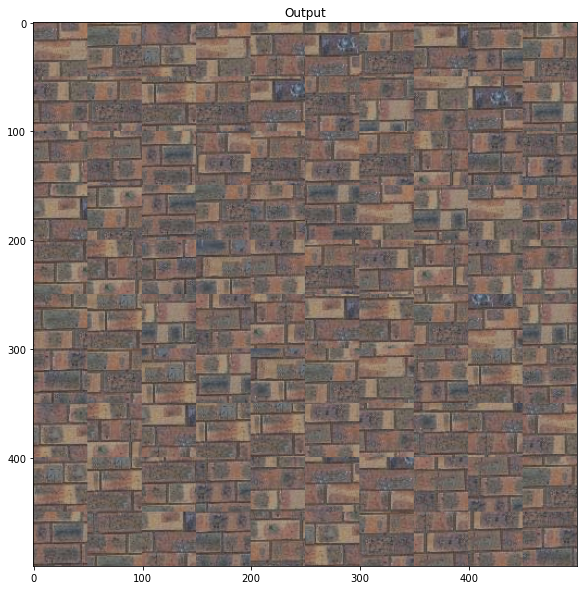

In [70]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.title('Sample Image')
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 50 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [5]:
def compute_SSD(mask, image, template):
    '''
    Computes the SSD cost image given a masked template, original image, and template patch.
    :param mask: numpy.ndarray
    :param image: numpy.ndarray
    :param sample: numpy.ndarray
    :return: numpy.ndarray
    '''
    # Compute these beforehand to make code look pretty
    mt_R = mask * template[:,:,0]
    mt_G = mask * template[:,:,1]
    mt_B = mask * template[:,:,2]
    
    # Compute SSD cost for each channel assuming data is in RGB
    cost_R = (mt_R**2).sum() - 2 \
              * cv2.filter2D(image[:,:,0], ddepth=-1, kernel=mt_R) \
              + cv2.filter2D(image[:,:,0] ** 2, ddepth=-1, kernel=mask)
    cost_G = (mt_R**2).sum() - 2 \
              * cv2.filter2D(image[:,:,1], ddepth=-1, kernel=mt_G) \
              + cv2.filter2D(image[:,:,1] ** 2, ddepth=-1, kernel=mask)
    cost_B = (mt_R**2).sum() - 2 \
              * cv2.filter2D(image[:,:,2], ddepth=-1, kernel=mt_B) \
              + cv2.filter2D(image[:,:,2] ** 2, ddepth=-1, kernel=mask)
    
    return cost_R + cost_G + cost_B


def ssd_patch(image, template, overlap, config=0):
    '''
    Computes SSD cost of the template patch against the original image to be sampled from.
    If config == 0, consider both left and upper overlaps.
    If config == 1, only consider left overlap.
    If config == 2, only consider upper overlap.
    :param image: numpy.ndarray
    :param template: numpy.ndarray
    :param overlap: int
    :param config: int
    :return: numpy.ndarray
    '''
    patch_dim = template.shape[0]
    masked_template = np.zeros((patch_dim, patch_dim), dtype=np.float32)
    
    if(config == 0): # left and upper overlap
        # Construct masked template
        masked_template[:overlap,:] = 1.0
        masked_template[:,:overlap] = 1.0
        # Compute SSD cost of template patch
        ssd_cost_img = compute_SSD(masked_template, image, template)
    elif(config == 1): # left overlap only
        masked_template[:,:overlap] = 1.0
        ssd_cost_img = compute_SSD(masked_template, image, template)
    elif(config == 2): # upper overlap only
        masked_template[:overlap,:] = 1.0
        ssd_cost_img = compute_SSD(masked_template, image, template)
    else:
        return None

    # Pad border of cost image with maximum values
    ssd_cost_img[:patch_dim,:] = np.finfo(np.float32).max
    ssd_cost_img[-patch_dim:,:] = np.finfo(np.float32).max
    ssd_cost_img[:,:patch_dim] = np.finfo(np.float32).max
    ssd_cost_img[:,-patch_dim:] = np.finfo(np.float32).max
    
    return ssd_cost_img
    
    
def choose_sample(cost, tol):
    '''
    Given SSD cost image, randomly selects a pixel within a given tolerance.
    :param cost: numpy.ndarray
    :param tol: int
    :return: (int, int)
    '''
    cost_1d = cost.flatten()
    idx = np.argsort(cost_1d, None)
    target = int(random() * tol+1)
    target = idx[target]
    
    return np.unravel_index(target, cost.shape)


def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Compute in floating point numbers
    sample_f = np.float32(sample) / 255
    out_img = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # Randomly generate coordinates from which to extract square patch
    sample_y, sample_x, _ = sample.shape
    y_rand = np.random.randint(low=0, high=(sample_y - patch_size - 1)) # Out-of-bounds protection
    x_rand = np.random.randint(low=0, high=(sample_x - patch_size - 1))
    
    # Copy and paste first sampled patch onto output image
    out_img[:patch_size, :patch_size, :] = sample_f[y_rand:y_rand+patch_size, x_rand:x_rand+patch_size, :]
    
    # Constant used in computing location within output image & image being sampled
    buffer = patch_size - overlap
    border = int((patch_size - 1) / 2)
    
    # Number of patches that can be fit on a single axis within given output size
    patch_dim = int((out_size - patch_size) / buffer) + 1
    
    # Construct quilted image
    for i in range(patch_dim):
        for j in range(patch_dim):
            template = out_img[buffer*i:buffer*i+patch_size, \
                               buffer*j:buffer*j+patch_size, :].copy()
            if(i == 0) and (j == 0): # Skip upper-leftmost patch
                continue
            elif(i == 0): # Uppermost row patches (left overlap only)
                target = choose_sample(ssd_patch(sample_f, template, overlap, 1), tol)
            elif(j == 0): # Leftmost column patches (upper overlap only)
                target = choose_sample(ssd_patch(sample_f, template, overlap, 2), tol)
            else: # 'Typical' patches (left and upper overlaps)
                target = choose_sample(ssd_patch(sample_f, template, overlap), tol)
                
            out_img[buffer*i:buffer*i+patch_size, \
                    buffer*j:buffer*j+patch_size, :] = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :]
            
    return out_img

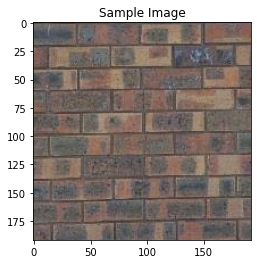

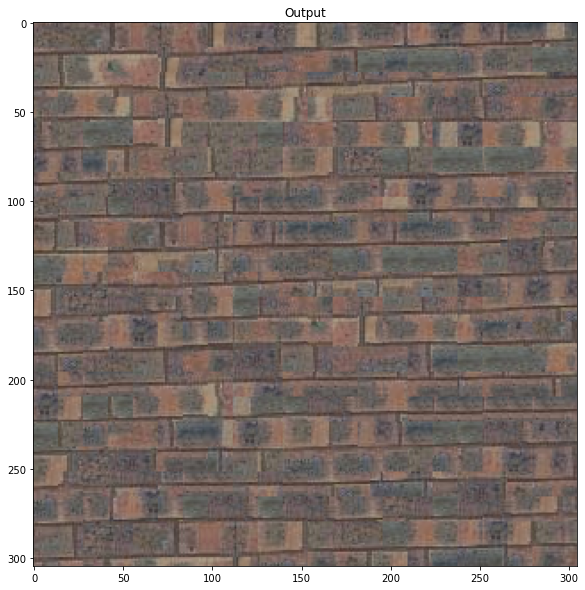

In [72]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.title('Sample Image')
plt.imshow(sample_img)
plt.show()

out_size = 305  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [7]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [76]:
def squared_diff(sample, template, overlap, config):
    '''
    Computes the squared differences between the overlapping region of given sample patch and template patch.
    If config == 0, uses left overlap
    If config == 1, uses upper overlap
    :param sample: numpy.ndarray
    :param template: numpy.ndarray
    :param overlap: int
    :param config: int
    :return: numpy.ndarray
    '''
    if(config == 0): # Left overlap
        out = np.zeros((sample.shape[0], overlap), dtype=np.float32)
        out += ((sample[:,:overlap,0] - template[:,:overlap,0]) ** 2) # Sum sqdiff over RGB channels
        out += ((sample[:,:overlap,1] - template[:,:overlap,1]) ** 2)
        out += ((sample[:,:overlap,2] - template[:,:overlap,2]) ** 2)
    elif(config == 1): # Upper overlap
        out = np.zeros((overlap, sample.shape[0]), dtype=np.float32)
        out += ((sample[:overlap,:,0] - template[:overlap,:,0]) ** 2)
        out += ((sample[:overlap,:,1] - template[:overlap,:,1]) ** 2)
        out += ((sample[:overlap,:,2] - template[:overlap,:,2]) ** 2)
    else:
        return None
    
    return out


def quilt_cut(sample, out_size, patch_size, overlap, tol, show_intermediate=0):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Compute in floating point numbers
    sample_f = np.float32(sample) / 255
    out_img = np.zeros((out_size, out_size, 3), dtype=np.float32)
    
    # Randomly generate coordinates from which to extract square patch
    sample_y, sample_x, _ = sample.shape
    y_rand = np.random.randint(low=0, high=(sample_y - patch_size - 1)) # Out-of-bounds protection
    x_rand = np.random.randint(low=0, high=(sample_x - patch_size - 1))
    
    # Copy and paste first sampled patch onto output image
    out_img[:patch_size, :patch_size, :] = sample_f[y_rand:y_rand+patch_size, x_rand:x_rand+patch_size, :]
    
    # Constant used in computing location within output image & image being sampled
    buffer = patch_size - overlap
    border = int((patch_size - 1) / 2)
    
    # Number of patches that can be fit on a single axis within given output size
    patch_dim = int((out_size - patch_size) / buffer) + 1
    
    # Construct quilted image
    for i in range(patch_dim):
        for j in range(patch_dim):
            template = out_img[buffer*i:buffer*i+patch_size, buffer*j:buffer*j+patch_size, :].copy()
            if(i == 0) and (j == 0): # Skip upper-leftmost patch
                continue
            elif(i == 0): # Uppermost row patches (left overlap only)
                # Get matching sample patch w/ SSD
                target = choose_sample(ssd_patch(sample_f, template, overlap, 1), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                # Create blank mask initialized to 1
                mask = np.ones((patch_size, patch_size))
                # Compute seam mask between template and sample patch and overwrite blank mask with seam mask
                mask[:,:overlap] = cut(squared_diff(target_patch, template, overlap, 0).T).T 
            elif(j == 0): # Leftmost column patches (upper overlap only)
                target = choose_sample(ssd_patch(sample_f, template, overlap, 2), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                mask = np.ones((patch_size, patch_size))
                mask[:overlap,:] = cut(squared_diff(target_patch, template, overlap, 1))
            else: # 'Typical' patches (left and upper overlaps)
                target = choose_sample(ssd_patch(sample_f, template, overlap), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                v_mask = np.ones((patch_size, patch_size))
                h_mask = np.ones((patch_size, patch_size))
                v_mask[:,:overlap] = cut(squared_diff(target_patch, template, overlap, 0).T).T
                h_mask[:overlap, :] = cut(squared_diff(target_patch, template, overlap, 1))
                mask = np.logical_and(v_mask, h_mask)
                
                # Obtain required assignment images for patch at 5,5
                if (show_intermediate == 1) and ((i == 5) and (j == 5)):
                    # Make a copy of current template and sample patches
                    temp_show = template.copy()
                    temp_show[-buffer:,-buffer:,:] = 0.0
                    tgt_show = target_patch.copy()
                    tgt_show[-buffer:,-buffer:,:] = 0.0
                    # Retrieve SSD cost image
                    cost_show = ssd_patch(sample_f, template, overlap)
                    # Replace high-cost border with max cost within border * 1.1
                    new_padding = cost_show[patch_size:-patch_size,patch_size:-patch_size].max()
                    new_padding *= 1.1
                    cost_show[:patch_size,:] = new_padding
                    cost_show[-patch_size:,:] = new_padding
                    cost_show[:,:patch_size] = new_padding
                    cost_show[:,-patch_size:] = new_padding
                    # Display as images
                    pt_seam, ax_seam = plt.subplots(2, 3, figsize=(10, 7))
                    ax_seam[0][0].set_title('Overlapping Template'), ax_seam[0][0].imshow(temp_show)
                    ax_seam[0][1].set_title('Overlapping Sample'), ax_seam[0][1].imshow(tgt_show)
                    ax_seam[0][2].set_title('SSD cost'), ax_seam[0][2].imshow(cost_show)
                    ax_seam[1][0].set_title('Horizontal Mask'), ax_seam[1][0].imshow(h_mask, cmap='gray')
                    ax_seam[1][1].set_title('Vertical Mask'), ax_seam[1][1].imshow(v_mask, cmap='gray')
                    ax_seam[1][2].set_title('Combined Mask'), ax_seam[1][2].imshow(mask, cmap='gray')

            # Mask out irrelevant pixels from sample patch in all channels
            target_patch[:,:,0] *= mask
            target_patch[:,:,1] *= mask
            target_patch[:,:,2] *= mask
               
            # Use pixel from template if corresponding mask pixel is zero, use pixel from sample otherwise
            out_img[buffer*i:buffer*i+patch_size, buffer*j:buffer*j+patch_size, :] \
            = np.where(target_patch > 0, target_patch, template)
            
    return out_img

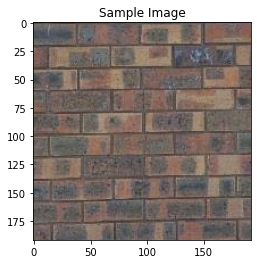

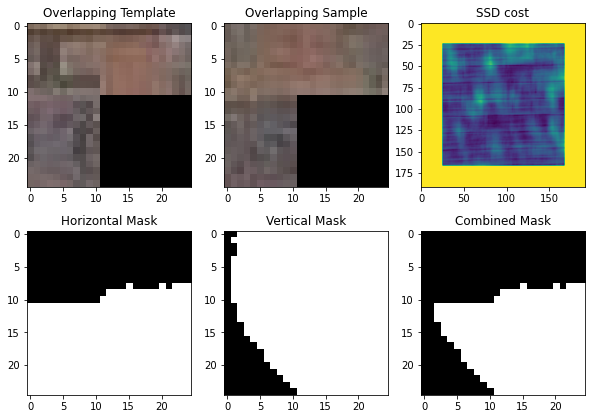

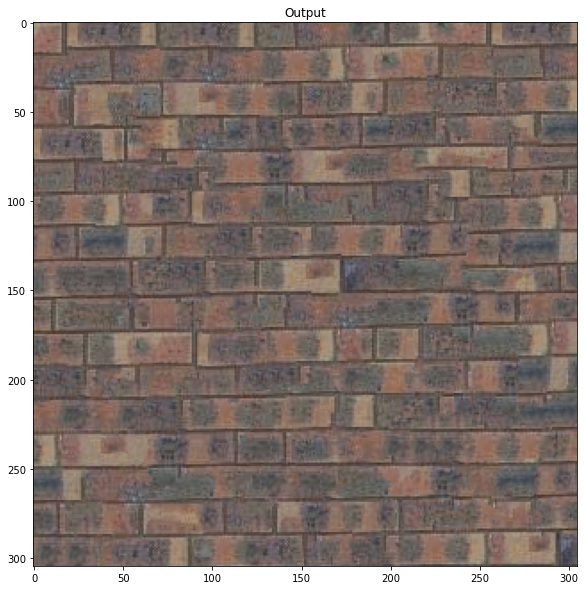

In [73]:
sample_img_fn = 'samples/bricks_small.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.title('Sample Image')
plt.imshow(sample_img)
plt.show()

out_size = 305  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol, 1)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)

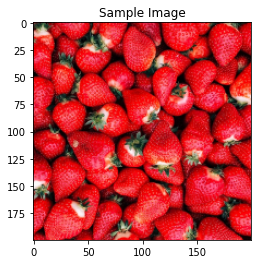

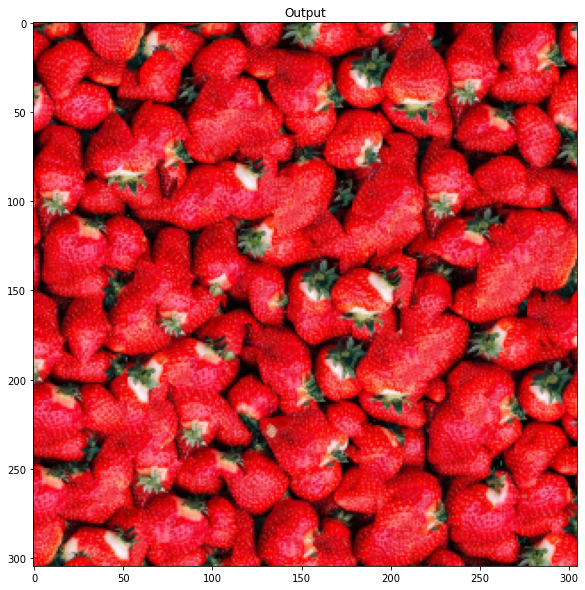

In [91]:
sample_img_fn = 'samples/seam1.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.title('Sample Image')
plt.imshow(sample_img)
plt.show()

out_size = 305   # change these parameters as needed
patch_size = 25
overlap = 11
tol = 3
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)

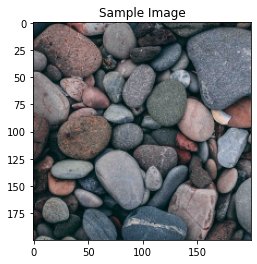

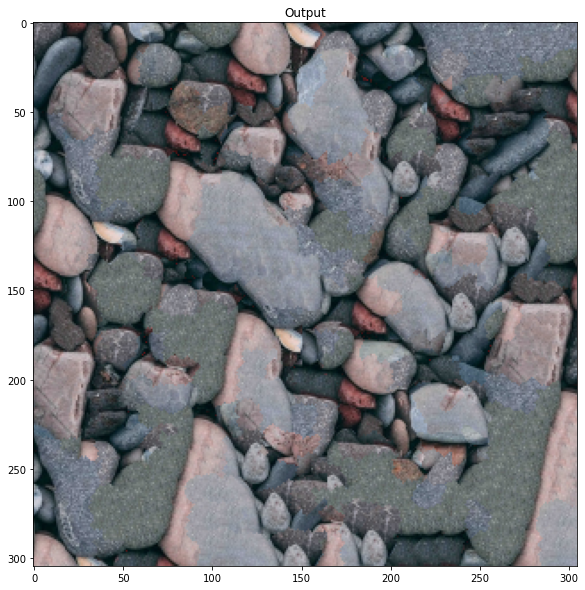

In [78]:
sample_img_fn = 'samples/seam2.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.title('Sample Image')
plt.imshow(sample_img)
plt.show()

out_size = 305  # change these parameters as needed
patch_size = 25
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [98]:
def getKernelSize(size, ratio=0.03):
    '''
    Returns a tuple of integers representing relative kernel size of given dimension.
    Taken from project 1.
    :param size: Tuple representing dimensions of image
    :param ratio: desired relative size of kernel
    :return: (int, int)
    '''
    y, x, _ = size
    
    # Select shorter dimension
    if x >= y:
        short = y
    else:
        short = x
        
    # Compute relative kernel size and round to integer
    raw_size = int(short*ratio)
    
    # Round up to odd integer
    if raw_size % 2 == 0:
        return (raw_size + 1, raw_size + 1)
    else:
        return (raw_size, raw_size)
    
    
def compute_SSD_grayscale(image, template):
    '''
    Grayscale version of compute_SSD.
    '''
    # Compute this beforehand to make code look pretty
    mask = np.ones((template.shape[0], template.shape[0]), dtype=np.float32) # Use no mask for SSD_transfer
    mt = mask * template
    
    # Compute SSD cost
    cost = (mt**2).sum() - 2 \
              * cv2.filter2D(image, ddepth=-1, kernel=mt) \
              + cv2.filter2D(image ** 2, ddepth=-1, kernel=mask)
    
    return cost


def ssd_patch_transfer(image, template, img_c, tmp_c, overlap, alpha, config=0):
    '''
    Texture transfer version of ssd_patch.
    Adds error of correspondance images to cost image.
    '''
    patch_dim = template.shape[0]
    masked_template = np.zeros((patch_dim, patch_dim), dtype=np.float32)
    
    if(config == 0): # left and upper overlap
        # Construct masked template
        masked_template[:overlap,:] = 1.0
        masked_template[:,:overlap] = 1.0
        # Compute SSD cost of template patch
        ssd_cost_img = alpha * compute_SSD(masked_template, image, template) \
                      + (1.0 - alpha) * compute_SSD_grayscale(img_c, tmp_c)
    elif(config == 1): # left overlap only
        masked_template[:,:overlap] = 1.0
        ssd_cost_img = alpha * compute_SSD(masked_template, image, template) \
                      + (1.0 - alpha) * compute_SSD_grayscale(img_c, tmp_c)
    elif(config == 2): # upper overlap only
        masked_template[:overlap,:] = 1.0
        ssd_cost_img = alpha * compute_SSD(masked_template, image, template) \
                      + (1.0 - alpha) * compute_SSD_grayscale(img_c, tmp_c)
    else:
        return None

    # Pad border of cost image with maximum values
    ssd_cost_img[:patch_dim,:] = np.finfo(np.float32).max
    ssd_cost_img[-patch_dim:,:] = np.finfo(np.float32).max
    ssd_cost_img[:,:patch_dim] = np.finfo(np.float32).max
    ssd_cost_img[:,-patch_dim:] = np.finfo(np.float32).max
    
    return ssd_cost_img
    
    
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    # Compute in floating point numbers
    sample_f = np.float32(sample) / 255
    out_img = np.zeros((guidance_im.shape[0], guidance_im.shape[1], 3), dtype=np.float32)
    
    # Compute correspondance maps of given images
    samp_kernel = getKernelSize(sample.shape)
    guid_kernel = getKernelSize(guidance_im.shape)
    border = cv2.BORDER_REFLECT
    samp_lum = np.float32(cv2.cvtColor(sample, cv2.COLOR_RGB2Lab)[:,:,0]) / 255 # Extract luminance values in float
    guid_lum = np.float32(cv2.cvtColor(guidance_im, cv2.COLOR_RGB2Lab)[:,:,0]) / 255
    corr_samp = cv2.GaussianBlur(samp_lum, samp_kernel, int(sample.shape[1]*0.3), borderType=border) # Gaussian blur
    corr_guid = cv2.GaussianBlur(guid_lum, guid_kernel, int(guidance_im.shape[1]*0.3), borderType=border)
    
    # Correspondance map sanity check
    pt, ax = plt.subplots(1,2)
    pt.suptitle('Correspondance Images')
    ax[0].imshow(corr_samp, cmap='gray'), ax[1].imshow(corr_guid, cmap='gray')
    
    # Randomly generate coordinates from which to extract square patch
    sample_y, sample_x, _ = sample.shape
    y_rand = np.random.randint(low=0, high=(sample_y - patch_size - 1)) # Out-of-bounds protection
    x_rand = np.random.randint(low=0, high=(sample_x - patch_size - 1))
    
    # Copy and paste first sampled patch onto output image
    out_img[:patch_size, :patch_size, :] = sample_f[y_rand:y_rand+patch_size, x_rand:x_rand+patch_size, :]
    
    # Constant used in computing location within output image & image being sampled
    buffer = patch_size - overlap
    border = int((patch_size - 1) / 2)
    
    # Number of patches that can be fit on a single axis within given output size
    patch_dim_y = int((out_img.shape[0] - patch_size) / buffer) + 1
    patch_dim_x = int((out_img.shape[1] - patch_size) / buffer) + 1
    
    # Construct quilted image
    for i in range(patch_dim_y):
        for j in range(patch_dim_x):
            # Get template patch
            template = out_img[buffer*i:buffer*i+patch_size, buffer*j:buffer*j+patch_size, :].copy()
            # Get correspondance patch from blurred guidance image
            corr_tmp = corr_guid[buffer*i:buffer*i+patch_size, buffer*j:buffer*j+patch_size]
            if(i == 0) and (j == 0): # Skip upper-leftmost patch
                continue
            elif(i == 0): # Uppermost row patches (left overlap only)
                # Get matching sample patch w/ SSD
                target = choose_sample(ssd_patch_transfer(sample_f, template, corr_samp, corr_tmp, \
                                                          overlap, alpha, 1), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                # Create blank mask initialized to 1
                mask = np.ones((patch_size, patch_size))
                # Compute seam mask between template and sample patch and overwrite blank mask with seam mask
                mask[:,:overlap] = cut(squared_diff(target_patch, template, overlap, 0).T).T 
            elif(j == 0): # Leftmost column patches (upper overlap only)
                target = choose_sample(ssd_patch_transfer(sample_f, template, corr_samp, corr_tmp, \
                                                          overlap, alpha, 2), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                mask = np.ones((patch_size, patch_size))
                mask[:overlap,:] = cut(squared_diff(target_patch, template, overlap, 1))
            else: # 'Typical' patches (left and upper overlaps)
                target = choose_sample(ssd_patch_transfer(sample_f, template, corr_samp, corr_tmp, \
                                                          overlap, alpha), tol)
                target_patch = sample_f[target[0]-border:target[0]+border+1, \
                                                                target[1]-border:target[1]+border+1, :].copy()
                v_mask = np.ones((patch_size, patch_size))
                h_mask = np.ones((patch_size, patch_size))
                v_mask[:,:overlap] = cut(squared_diff(target_patch, template, overlap, 0).T).T
                h_mask[:overlap, :] = cut(squared_diff(target_patch, template, overlap, 1))
                mask = np.logical_and(v_mask, h_mask)

            # Mask out irrelevant pixels from sample patch in all channels
            target_patch[:,:,0] *= mask
            target_patch[:,:,1] *= mask
            target_patch[:,:,2] *= mask
               
            # Use pixel from template if corresponding mask pixel is zero, use pixel from sample otherwise
            out_img[buffer*i:buffer*i+patch_size, buffer*j:buffer*j+patch_size, :] \
            = np.where(target_patch > 0, target_patch, template)
            
    return out_img

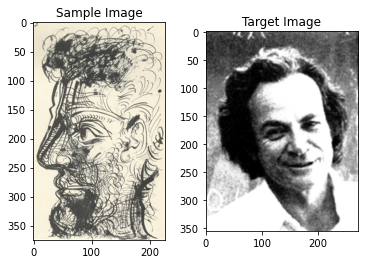

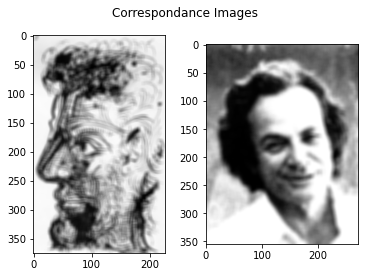

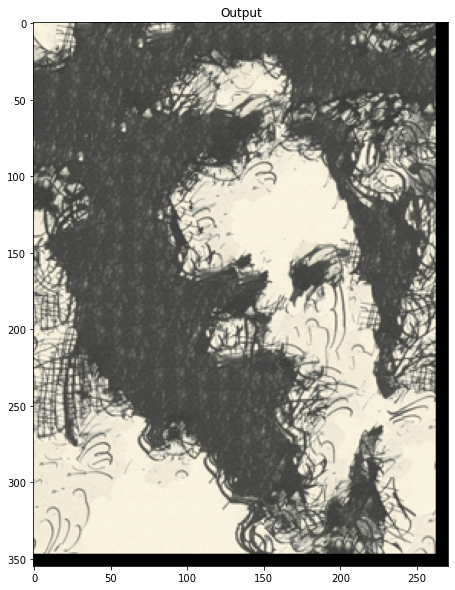

In [99]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
pt, ax = plt.subplots(1,2)
ax[0].imshow(texture_img), ax[0].set_title('Sample Image')
ax[1].imshow(guidance_img), ax[1].set_title('Target Image')

patch_size = 25
overlap = 11
tol = 3
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)
    plt.show()

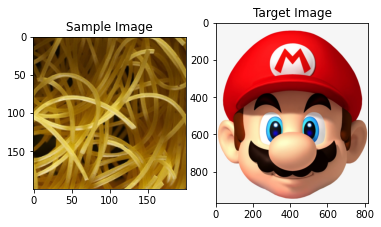

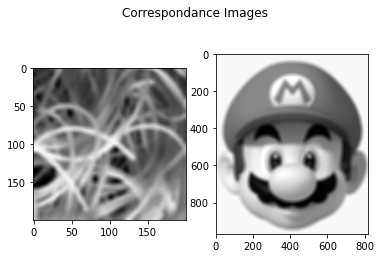

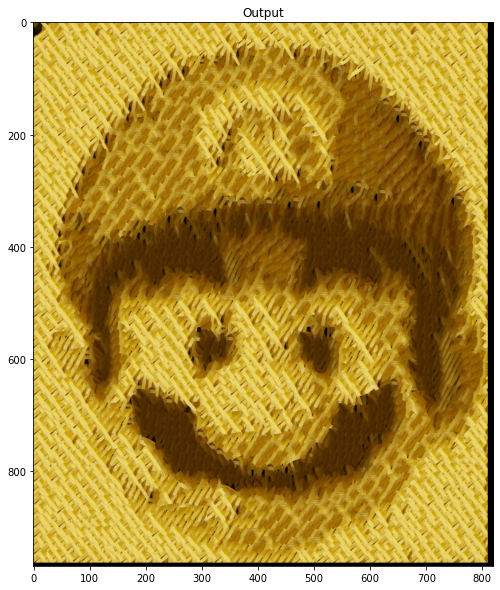

In [100]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/transfer.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/transfer_tgt.jpg' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
pt, ax = plt.subplots(1,2)
ax[0].imshow(texture_img), ax[0].set_title('Sample Image')
ax[1].imshow(guidance_img), ax[1].set_title('Target Image')

patch_size = 25
overlap = 11
tol = 5
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

if res is not None:
    plt.figure(figsize=(10,10))
    plt.title('Output')
    plt.imshow(res)
    plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).